# 用TensorFlow實作圖片分類
卷積神經網絡（Convolutional Neural Network, CNN）是一種前饋神經網絡，它的人工神經元可以響應一部分覆蓋範圍內的周圍單元，對於大型圖像處理有出色表現。
<img src="img/CNN架構.jpg" width="800px" /><br>
卷積神經網絡由一個或多個卷積層(convolutions layer)和頂端的全連通層（對應經典的神經網絡）組成，同時也包括關聯權重和池化層（pooling layer）。這一結構使得卷積神經網絡能夠利用輸入數據的二維結構。與其他深度學習結構相比，卷積神經網絡在圖像和語音識別方面能夠給出更好的結果。這一模型也可以使用反向傳播算法進行訓練。<br><br>
## 卷積層(convolutions layer)
卷積層就像一台掃模器，一次掃較小的圖塊，掃出來的結果就會是更高維度、大小更小的照片集，如下圖所示。
<img src="img/convolutions_2.jpg" width="400px" /><br>
<img src="img/convolutions.jpg" width="400px" /><br>
## 池化層(pooling layer)
池化層是卷積神經網絡中另一個重要的概念，它實際上是一種形式的降採樣。有多種不同形式的非線性池化函數，而其中「最大池化（Max pooling）」是最為常見的。它是將輸入的圖像劃分為若干個矩形區域，對每個子區域輸出最大值。直覺上，這種機制能夠有效地原因在於，在發現一個特徵之後，它的精確位置遠不及它和其他特徵的相對位置的關係重要。池化層會不斷地減小數據的空間大小，因此參數的數量和計算量也會下降，這在一定程度上也控制了過擬合。通常來說，CNN的卷積層之間都會周期性地插入池化層。<br>

池化層通常會分別作用於每個輸入的特徵並減小其大小。目前最常用形式的池化層是每隔2個元素從圖像劃分出2*2的區塊，然後對每個區塊中的4個數取最大值。這將會減少75%的數據量。<br>
<img src="img/pool.jpg" width="400px" />
<img src="img/pool_2.jpg" width="400px" /><br>
經過數個卷積層和池化層後，剩下的就是一塊一塊小圖片，並且厚度會逐漸加厚(圖片數量變多)，那麼這些小圖片就是CNN network抽取出來的特徵，將這些特徵再往下接到MLP network(hidden layer)，最後分成數個類別，再輸出層(output layer)，假設我要分成10個種類，那最後10個layer分別會帶有不同的數字(這些數字加總為1)，代表模組經過學習後，認為這張圖片為哪項分類的機率，而我們當然是選擇機率最大的為最後分類結果(softmax)。

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2

Using TensorFlow backend.


In [2]:
#定義畫圖funtion
import matplotlib.pyplot as plt
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "lable=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "lable={},prediction={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "lable={}".format(str(labels[idx])) 
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])
        idx+=1
    plt.show()

In [3]:
#讀取mapping並寫入data frame裡，方便後續做分類、抓取資料
mapping_df = pd.read_csv('//data/examples/may_the_4_be_with_u/where_am_i/mid_term_mapping.txt' ,header=None)
mapping_df.columns = ['folder_name', 'label']
mapping_df.sample(5)

,folder_name,label
10,mountain,8
12,store,11
3,coast,10
6,industrial,2
0,CALsuburb,9


In [4]:
test_submit_df = pd.read_csv('//data/examples/may_the_4_be_with_u/where_am_i/img-submission.csv')
#test_submit_df.columns = ['file_name', 'label']
print(len(test_submit_df))

1500


In [5]:
#所有的照片已經預先分類在15個資料夾中，所以透過mapping_df[folder_name]，我們可以造訪所有的train data並記下每張圖片的路徑
import os
image_mapping_path_df = pd.DataFrame(columns=['folder_name', 'label', 'path'])
path = "//data/examples/may_the_4_be_with_u/where_am_i/"
pathData = []
for x in range(0, len(mapping_df['folder_name'])):
    folder_name = mapping_df['folder_name'][x]
    label = mapping_df['label'][x]
    class_folder = path + "train/" + folder_name
    for train_imgName in os.listdir(class_folder):
        train_data_path = class_folder + "/" + train_imgName
        s = pd.DataFrame([[folder_name, label, train_data_path]],columns=['folder_name', 'label', 'path'])
        image_mapping_path_df = image_mapping_path_df.append(s, ignore_index=True)
image_mapping_path_df.sample(5)

,folder_name,label,path
926,highway,14.0,//data/examples/may_the_4_be_with_u/where_am_i...
760,forest,4.0,//data/examples/may_the_4_be_with_u/where_am_i...
1924,mountain,8.0,//data/examples/may_the_4_be_with_u/where_am_i...
652,forest,4.0,//data/examples/may_the_4_be_with_u/where_am_i...
481,coast,10.0,//data/examples/may_the_4_be_with_u/where_am_i...


In [6]:
#接著利用剛剛記下的路徑，抓取每張圖片，並設定大小
image_width = 128
image_high = 128
#image_cnn_shape是我在cnn層最後每張圖片的大小，因為總共做了4次 pool每次都取2*2，所以長、寬分別剩下1/16
image_cnn_shape = (image_width//16) * (image_high//16)
image = cv2.imread(image_mapping_path_df["path"][0])
image = cv2.resize(image, (image_width, image_high))
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#train = np.reshape(image, (32, 32))
train = np.expand_dims(image, axis=0)
#train = np.reshape(image, (1, 262, 200))
train_label = np.zeros(0, dtype=float)
train_label = np.append(train_label, image_mapping_path_df["label"][0])
for x in range(1, len(image_mapping_path_df)):
    path = image_mapping_path_df["path"][x]
    label = image_mapping_path_df["label"][x]
    image = cv2.imread(path)
    image = cv2.resize(image, (image_width, image_high))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #train = np.reshape(image, (32, 32))
    image = np.expand_dims(image, axis=0)
    train = np.concatenate((train,image), axis=0)
    train_label = np.append(train_label, label)

print("\t[Info] Shape of train data=%s" % (str(train.shape)))
print("\t[Info] Shape of train label=%s" % (str(train_label.shape)))

	[Info] Shape of train data=(2985, 128, 128, 3)
	[Info] Shape of train label=(2985,)


In [7]:
path = "//data/examples/may_the_4_be_with_u/where_am_i/"
test_path = path + "testset/"
image = cv2.imread(test_path + test_submit_df["id"][0] + ".jpg")
image = cv2.resize(image, (image_width, image_high))
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
test = np.expand_dims(image, axis=0)
for x in range(1, len(test_submit_df)):
    path = test_path + test_submit_df["id"][x] + ".jpg"
    image = cv2.imread(path)
    image = cv2.resize(image, (image_width, image_high))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=0)
    test = np.concatenate((test,image), axis=0)
    
test_label = np.zeros(0, dtype=float)

print("\t[Info] Shape of test data=%s" % (str(test.shape)))
print("\t[Info] Shape of test_label=%s" % (str(test_label.shape)))

	[Info] Shape of test data=(1500, 128, 128, 3)
	[Info] Shape of test_label=(0,)


# 數據增強(ImageDataGenerator)
在train data數量不足時，可以透過數據增強的方式，生成新的數據。<br>
數據增強有很多種方式，例如:選轉圖片、翻轉圖片、將圖片比例縮放、白化、平行拉長...<br>
這邊我實作時，用的是keras的API，在下面附上所有參數。<br>
featurewise_center：布尔值，使输入数据集去中心化（均值为0）, 按feature执行

samplewise_center：布尔值，使输入数据的每个样本均值为0

featurewise_std_normalization：布尔值，将输入除以数据集的标准差以完成标准化, 按feature执行

samplewise_std_normalization：布尔值，将输入的每个样本除以其自身的标准差

zca_whitening：布尔值，对输入数据施加ZCA白化

zca_epsilon: ZCA使用的eposilon，默认1e-6

rotation_range：整数，数据提升时图片随机转动的角度

width_shift_range：浮点数，图片宽度的某个比例，数据提升时图片水平偏移的幅度

height_shift_range：浮点数，图片高度的某个比例，数据提升时图片竖直偏移的幅度

shear_range：浮点数，剪切强度（逆时针方向的剪切变换角度）

zoom_range：浮点数或形如[lower,upper]的列表，随机缩放的幅度，若为浮点数，则相当于[lower,upper] = [1 - zoom_range, 1+zoom_range]

channel_shift_range：浮点数，随机通道偏移的幅度

fill_mode：；‘constant’，‘nearest’，‘reflect’或‘wrap’之一，当进行变换时超出边界的点将根据本参数给定的方法进行处理

cval：浮点数或整数，当fill_mode=constant时，指定要向超出边界的点填充的值

horizontal_flip：布尔值，进行随机水平翻转

vertical_flip：布尔值，进行随机竖直翻转

rescale: 重放缩因子,默认为None. 如果为None或0则不进行放缩,否则会将该数值乘到数据上(在应用其他变换之前)

preprocessing_function: 将被应用于每个输入的函数。该函数将在图片缩放和数据提升之后运行。该函数接受一个参数，为一张图片（秩为3的numpy array），并且输出一个具有相同shape的numpy array

data_format：字符串，“channel_first”或“channel_last”之一，代表图像的通道维的位置。该参数是Keras 1.x中的image_dim_ordering，“channel_last”对应原本的“tf”，“channel_first”对应原本的“th”。以128x128的RGB图像为例，“channel_first”应将数据组织为（3,128,128），而“channel_last”应将数据组织为（128,128,3）。该参数的默认值是~/.keras/keras.json中设置的值，若从未设置过，则为“channel_last”
<br>
參考資料:https://keras-cn.readthedocs.io/en/latest/preprocessing/image/

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=False)

# 計算特徵正規化所需的數量
datagen.fit(train)
x_IDG_train = train
y_IDG_label = train_label

#決定我要生成幾倍的資料量
for e in range(10):
    print('Data Gene epochs =',e)
    batches=0
    per_batch=32
    #每次的batch_size生成數據
    for x_batch,y_batch in datagen.flow(train,train_label,batch_size=32):
        x_IDG_train = np.concatenate((x_IDG_train, x_batch), axis = 0)
        y_IDG_label = np.concatenate((y_IDG_label, y_batch), axis = 0)
        batches += 1
        if batches >= len(train) / per_batch:
        # 需要手動跳出迴圈
            break
print('Data Augment(x_IDG_train) total shape =',x_IDG_train.shape)
print('Data Augment(y_IDG_label) total shape =',y_IDG_label.shape)
print("-------------------")

Data Gene epochs = 0
Data Gene epochs = 1
Data Gene epochs = 2
Data Gene epochs = 3
Data Gene epochs = 4
Data Gene epochs = 5
Data Gene epochs = 6
Data Gene epochs = 7
Data Gene epochs = 8
Data Gene epochs = 9
Data Augment(x_IDG_train) total shape = (32835, 128, 128, 3)
Data Augment(y_IDG_label) total shape = (32835,)
-------------------


# 正規化
正規化對CNN模組在學習上有"非常非常非常"大的重要性，如果在沒有做正規化的情況下training model，那麼model學習的效率會非常低，幾乎學不起來。選擇除以255的原因在於，圖片上每個像素的值屆於0~255之間，除以255可以讓所有值屆於0~1之間。

In [9]:
#train = x_IDG_train.reshape(len(x_IDG_train), image_width*image_high).astype('float32')
#test = y_IDG_label.reshape(len(y_IDG_label), image_width*image_high).astype('float32')
print("\t[Info] x_IDG_train: %s" % (str(x_IDG_train.shape)))
print("\t[Info] y_IDG_label: %s" % (str(y_IDG_label.shape)))

# Normalization
x_IDG_train = x_IDG_train/255
#test = test/255

	[Info] x_IDG_train: (32835, 128, 128, 3)
	[Info] y_IDG_label: (32835,)


In [10]:
image = x_IDG_train[0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
train = np.expand_dims(image, axis=0)
for i in tqdm(range(1, len(x_IDG_train))):
    image = x_IDG_train[i]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=0)
    train = np.concatenate((train,image), axis=0)
train.shape

100%|██████████| 32834/32834 [3:21:07<00:00,  2.72it/s]


(32835, 128, 128)

In [11]:
train[0]

array([[ 0.1882353 ,  0.1882353 ,  0.1882353 , ...,  0.44705886,
         0.48627454,  0.42352942],
       [ 0.1882353 ,  0.1882353 ,  0.1882353 , ...,  0.4627451 ,
         0.4666667 ,  0.43921569],
       [ 0.19215687,  0.19215687,  0.19215687, ...,  0.47843137,
         0.4666667 ,  0.41960785],
       ..., 
       [ 0.32156864,  0.3137255 ,  0.31764707, ...,  0.3764706 ,
         0.3882353 ,  0.38431373],
       [ 0.3019608 ,  0.3137255 ,  0.32941177, ...,  0.35686275,
         0.38039216,  0.3764706 ],
       [ 0.30980393,  0.32156864,  0.33725491, ...,  0.32549021,
         0.34901962,  0.34901962]], dtype=float32)

In [12]:
y_TrainOneHot = np_utils.to_categorical(y_IDG_label) # 將 training 的 label 進行 one-hot encoding
print("y_TrainOneHot.shape = ",y_TrainOneHot.shape)
print(y_IDG_label[0]) # 檢視 training labels 第一個 label 的值
y_TrainOneHot[:1] # 檢視第一個 label 在 one-hot encoding 後的結果, 會在第10個位置上為 1, 其他位置上為 0

y_TrainOneHot.shape =  (32835, 15)
9.0


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.]])

In [13]:
#----------------------------資料training set, testing set 分割---------------------------------------
x_train, x_valid, y_train, y_valid = train_test_split(train,
                                                    y_TrainOneHot,
                                                    test_size = 0.2,
                                                    stratify  = y_TrainOneHot.argmax(axis = 1))
print("training set: %i" % len(x_train))
print("test set: %i" % len(x_valid))

training set: 26268
test set: 6567


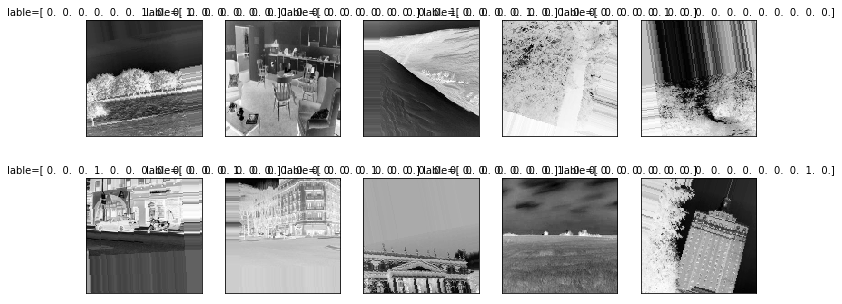

In [14]:
plot_images_labels_predict(x_train,y_train, [], 6000)

# 定義模組
以下例子中，我用tensorflow架構了四層convolutions layer，並在每一層後面，都接上pool 2*2，做完pool要進入下一層之前，drop 25%神經元，讓模組在學習時，不會太容易overfitting。在CNN之後，我接上兩層的MLP，第一層 layer數量是512，第二層 layer數量是128，最後經過softmax分類成15類。(out put layer)<br>
## drop
drop在解決overfittimg時，是非常有用的方式，因為model在每次進入下一層之前，都遺失了一些訊號，那麼自然不可能過度學習啦!

In [17]:
from __future__ import print_function
import tensorflow as tf

batch_size = 16
epochs = 200
lr = 0.001
hidden1_neurons = 512
hidden2_neurons = 256

#def compute_accuracy(v_xs, v_ys):
#    global prediction
#    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
#    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
#    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
#    return result

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, image_width, image_high])   # 128*128
ys = tf.placeholder(tf.float32, [None, 15])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(xs, [-1, image_width, image_high, 1])
# print(x_image.shape)  # [n_samples, 256,200,1]

## conv1 layer ##
W_conv1 = weight_variable([5,5, 1,32]) # patch 5x5, in size 1, out size 32
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 128x128x32
h_pool1 = max_pool_2x2(h_conv1)                          # output size 64x64x32
h_pool1_drop = tf.nn.dropout(h_pool1, keep_prob)

## conv2 layer ##
W_conv2 = weight_variable([5,5, 32, 64]) # patch 5x5, in size 32, out size 64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1_drop, W_conv2) + b_conv2) # output size 64x64x64
h_pool2 = max_pool_2x2(h_conv2)                          # output size 32x32x64
h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob)

## conv3 layer ##
W_conv3 = weight_variable([5,5, 64, 128]) # patch 5x5, in size 64, out size 128
b_conv3 = bias_variable([128])
h_conv3 = tf.nn.relu(conv2d(h_pool2_drop, W_conv3) + b_conv3) # output size 32x32x128
h_pool3 = max_pool_2x2(h_conv3)                          # output size 16x16x64
h_pool3_drop = tf.nn.dropout(h_pool3, keep_prob)

## conv4 layer ##
W_conv4 = weight_variable([5,5, 128, 256]) # patch 5x5, in size 128, out size 256
b_conv4 = bias_variable([256])
h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4) # output size 16x16x256
h_pool4 = max_pool_2x2(h_conv4)                          # output size 4x4x256
h_pool4_drop = tf.nn.dropout(h_pool4, keep_prob)

## fc1 layer ##
W_fc1 = weight_variable([image_cnn_shape*256, hidden1_neurons])
b_fc1 = bias_variable([hidden1_neurons])
#[n_samples, 4*4*64]
h_pool4_flat = tf.reshape(h_pool4_drop, [-1, image_cnn_shape*256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## fc2 layer ##
W_fc2 = weight_variable([hidden1_neurons, hidden2_neurons])
b_fc2 = bias_variable([hidden2_neurons])
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

## fc3 layer ##
W_fc3 = weight_variable([hidden2_neurons, 15])
b_fc3 = bias_variable([15])
output = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
pre = tf.nn.softmax(output)

# the error between prediction and real data
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), reduction_indices=[1]))       # loss
#train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(cross_entropy)

with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=ys))

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(output),1), tf.argmax(ys,1)) #如果答案對則回傳true
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #將回傳的true/false轉乘1/0並計算平均(計算正確率)

with tf.name_scope('train'):
    #使用adam做optimization最小化loss funciotn(不斷取微分並逼近local min)
    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [18]:
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []

sess = tf.Session()
# important step
# tf.initialize_all_variables() no long valid from
init = tf.global_variables_initializer()
sess.run(init)

#for i in range(100):
#    batch_xs, batch_ys = mnist.train.next_batch(100)
#    sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.5})
#    if i % 50 == 0:
#        print(compute_accuracy(
#            mnist.test.images[:1000], mnist.test.labels[:1000]))


for i in tqdm(range(epochs)):
    # get batch
    batches = 0
    total_batch = int(np.floor(len(x_train) / batch_size)) # just drop out last few samples...
    
    train_loss_collector, train_acc_collector = [], []
    for j in np.arange(total_batch):
        batch_idx_start = j * batch_size
        batch_idx_stop = (j+1) * batch_size

        x_batch = x_train[batch_idx_start : batch_idx_stop]
        y_batch = y_train[batch_idx_start : batch_idx_stop]
            
        this_loss, this_acc, _ = sess.run([loss, compute_acc, train_step], feed_dict = {xs: x_batch, ys: y_batch, keep_prob: 0.75})
        train_loss_collector.append(this_loss)
        train_acc_collector.append(this_acc)
            
        # do validation at the end of each epoch
    valid_acc, valid_loss = sess.run([compute_acc, loss], feed_dict = {xs: x_valid, ys : y_valid, keep_prob: 0.75})
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    train_loss_list.append(np.mean(train_loss_collector))
    train_acc_list.append(np.mean(train_acc_collector))

    # at the end of each epoch, shuffle the data
    x_train, y_train = shuffle(x_train, y_train)
# At the end of the training, do testing set
valid_acc, valid_loss = sess.run([compute_acc, loss], feed_dict = {xs: x_valid, ys : y_valid, keep_prob: 0.75})
result = sess.run(pre, feed_dict={xs: x_valid, ys: y_valid, keep_prob: 0.75})

saver = tf.train.Saver()
model_path = "model_1/model.ckpt"
save_path = saver.save(sess, model_path)

print('--- training done ---')
print('accuracy: %.2f' % valid_acc)
#--------------------------------------plot---------------------------------------------
print("loss")
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, 'r', label = 'valid')
plt.legend()
plt.show()

print("accuracy")
plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b', label = 'train')
plt.plot(np.arange(len(valid_acc_list)), valid_acc_list, 'r', label = 'valid')
plt.legend(loc = 4)
plt.show()


  0%|          | 0/200 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




ResourceExhaustedError: OOM when allocating tensor with shape[6567,128,128,32]
	 [[Node: Conv2D_4 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Reshape_2, Variable_14/read)]]
	 [[Node: accuracy_1/Mean/_23 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_189_accuracy_1/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Conv2D_4', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-2bd8aa03638f>", line 45, in <module>
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 128x128x32
  File "<ipython-input-17-2bd8aa03638f>", line 29, in conv2d
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[6567,128,128,32]
	 [[Node: Conv2D_4 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Reshape_2, Variable_14/read)]]
	 [[Node: accuracy_1/Mean/_23 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_189_accuracy_1/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


# 混淆矩陣
我們可以透過混淆矩陣，觀察分類錯誤的情況。

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
#Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(result, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(15))

<img src="img/result.jpg"/>